# **Downloading Data**
https://www.kaggle.com/datasets/quora/question-pairs-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/docs/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d quora/question-pairs-dataset
! unzip question-pairs-dataset.zip -d data/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
question-pairs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  question-pairs-dataset.zip
replace data/questions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# **Initializing**

In [ ]:
PATH = "/content/data/questions.csv"
DUMP_PATH = "/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/"

In [ ]:
SAMPLE_SIZE = None
MIN_LEN_ALLOWED = 3
ALLOW_STOPWORDS = False

In [ ]:
! pip install distance
! pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 KB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=7b86185969c268e3e5654a4d947a0117d8a541921bf8a925dc158f3c4d8e7352
  Stored in directory: /root/.cache/pip/wheels/fb/a8/64/6edcab63ec51512a87cacf9b3563c711ad6b7b05d61b704493
Successfully built distance
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import distance
from fuzzywuzzy import fuzz
from tqdm import tqdm

/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
df = pd.read_csv(PATH)
orig_df = pd.read_csv(PATH)

# Removing Short Question Rows
short_question_rows = [i for i in range(len(df)) if len(str(df['question1'].iloc[i]).split()) < MIN_LEN_ALLOWED or len(str(df['question2'].iloc[i]).split()) < MIN_LEN_ALLOWED]
df = df.drop(df.index[short_question_rows])

# Removing Duplicates
df.drop_duplicates(inplace=True)

# Shuffling the Dataset
df = df.sample(df.shape[0], random_state=42)

# Picking a sample
if SAMPLE_SIZE == None:
    SAMPLE_SIZE = min(df.is_duplicate.value_counts().values) * 2
df = pd.concat([
    df[df.is_duplicate == 0].iloc[:SAMPLE_SIZE//2],
    df[df.is_duplicate == 1].iloc[:SAMPLE_SIZE//2]
])

# Shuffling the Dataset Again
df = df.sample(df.shape[0],random_state=2)

print("SAMPLE_SIZE", SAMPLE_SIZE)
print(df.shape)
df.sample(5)

SAMPLE_SIZE 298550
(298550, 6)


,id,qid1,qid2,question1,question2,is_duplicate
155442,155442,307417,307418,Which is better Bharti Vidyapeeth college of e...,What is your review of SRM University?,0
307239,307239,603193,181078,Which are the best stocks to buy in India?,What are the best stocks to buy in the Indian ...,1
106019,106019,210282,210283,Who was the best among Pandavas?,Who was the best Pandava?,1
91019,91019,180715,180716,What can I present in the computer exhibition ...,What is the future for visual presentation and...,0
293949,293949,577455,577456,How do I cure asthma?,How do we treat asthma?,1


# **Exploratory Data Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298550 entries, 81424 to 42173
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            298550 non-null  int64 
 1   qid1          298550 non-null  int64 
 2   qid2          298550 non-null  int64 
 3   question1     298550 non-null  object
 4   question2     298550 non-null  object
 5   is_duplicate  298550 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 15.9+ MB


In [ ]:
# missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
# duplicate rows
df.duplicated().sum()

0

1    149275
0    149275
Name: is_duplicate, dtype: int64
1    50.0
0    50.0
Name: is_duplicate, dtype: float64


<AxesSubplot:>

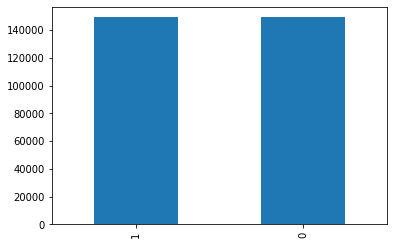

In [ ]:
# Distribution of duplicate and non-duplicate questions

print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [ ]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 586798
Number of questions getting repeated 7519


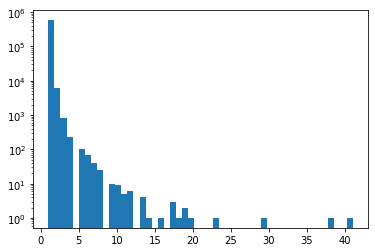

In [ ]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=50)
plt.yscale('log')
plt.show()

# **Preprocessing**

## Cleaning

In [ ]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

abbv = {
    "AFAIK":"as far as I know", "IMO":	"in my opinion", "IMHO":	"in my humble opinion", "LGTM":	"look good to me", "AKA":	"also know as", "ASAP":	"as sone as possible", "BTW":	"by the way", "FAQ":	"frequently asked questions", "DIY":	"do it yourself", "DM":	"direct message", "FYI":	"for your information", "IC":	"i see", "IOW":	"in other words", "IIRC":	"If I Remember Correctly", "icymi":"In case you missed it", "CUZ":	"because", "COS":	"because", "nv":	"nevermind", "PLZ":	"please",
}

# https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
# https://stackoverflow.com/a/19794953
contractions = { 
    "ain't": "am not", "aren't": "are not", "can't": "can not", "can't've": "can not have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "'ve": " have", "n't": " not", "'re": " are", "'ll": " will",
}

import re
html_pattern = re.compile('<.*?>')
urls_pattern = re.compile(r'https?://\S+|www\.\S+')
emoji_pattern = re.compile("["
	u"\U0001F600-\U0001F64F"  # emoticons
	u"\U0001F300-\U0001F5FF"  # symbols & pictographs
	u"\U0001F680-\U0001F6FF"  # transport & map symbols
	u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
"]+", flags=re.UNICODE)

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import string
punc = string.punctuation

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def preprocess(q, allow_stopwords=True):
    
    q = str(q).lower().strip()

    # HTML Tags
    q = html_pattern.sub(r'', q)

    # urls
    q = urls_pattern.sub(r'', q)

    # punctuations
    q = q.translate(str.maketrans("", "", punc))

    # Emojis
    q = emoji_pattern.sub(r'', q)
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    new_text = []

    for word in q.split():

        # Contractions
        word = contractions.get(word.upper(), word)

        # abbreviations
        word = abbv.get(word.upper(), word)
            
        # Stemming
        # word = ps.stem(word)

        # Lemmatizing
        word = lemmatizer.lemmatize(word)

        if word not in stopwords or allow_stopwords:
            new_text.append(word)

    q = ' '.join(new_text)

    
    return q

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
preprocess("I've already! wasn't <b>done</b>? There is a big tree")

'ive already wasnt done there is a big tree'

In [ ]:
preprocess("I've already! wasn't <b>done</b>? There is a big tree", allow_stopwords=False)

'ive already wasnt done big tree'

In [ ]:
df['question1'] = df['question1'].apply(lambda x: preprocess(x, allow_stopwords=ALLOW_STOPWORDS))
df['question2'] = df['question2'].apply(lambda x: preprocess(x, allow_stopwords=ALLOW_STOPWORDS))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
81424,81424,161740,161741,cant india get medal every olympics,indian get le medal olympics,1
350428,350428,686512,686513,car accident common among high school student ...,carriage accident le common car accident today,0
162442,162442,321149,321150,conceptual analysis,conceptual model,0
261498,261498,514570,514571,eye lord ring,powerful lord ring,0
70085,70085,139301,139302,management art science,management science art,1


## Cosine Similarity

In [ ]:
from numpy.linalg import norm
SAFE_DIV = 0.0001

def cos_sim(q1, q2, allow_stopwords=True):
    q1 = [i for i in q1.split() if i not in stopwords or allow_stopwords]
    q2 = [i for i in q2.split() if i not in stopwords or allow_stopwords]

    vocab = set(q1 + q2)

    vocab1 = dict(zip(vocab, [0]*len(vocab)))
    vocab2 = dict(zip(vocab, [0]*len(vocab)))

    for w in q1:
        vocab1[w] += 1
    for w in q2:
        vocab2[w] += 1

    v1 = list(vocab1.values())
    v2 = list(vocab2.values())

    return (np.dot(v1,v2) + SAFE_DIV)/(norm(v1)*norm(v2) + SAFE_DIV)


cos_sim("hello from the other side", "hi from ali's side", allow_stopwords=ALLOW_STOPWORDS)

0.40827244764003007

In [ ]:
sims = []
for q1, q2 in tqdm(zip(df['question1'].values, df['question2'].values)):
    sims.append(cos_sim(str(q1), str(q2), allow_stopwords=ALLOW_STOPWORDS))
df['cos_sim'] = sims

298550it [00:28, 10604.18it/s]


### Visualizing Features

In [ ]:
anas = []
thres = []
sample_pers = []
zer_pers = []

for i in np.linspace(0.1, 0.9, num=17):
    SIM_THRESH = i

    vc = df[df['cos_sim'] < SIM_THRESH].is_duplicate.value_counts()
    sample_per = vc.sum() * 100 / len(df)
    zer_per = (vc / vc.sum())[0] * 100

    anas.append({
        "thresh": SIM_THRESH,
        "sample_per": sample_per,
        "zer_per": zer_per,
    })
    thres.append(SIM_THRESH)
    sample_pers.append(sample_per)
    zer_pers.append(zer_per)

In [ ]:
anas

[{'thresh': 0.1,
  'sample_per': 7.776921788645118,
  'zer_per': 99.67697476096133},
 {'thresh': 0.15000000000000002,
  'sample_per': 8.867526377491208,
  'zer_per': 99.69026214399032},
 {'thresh': 0.2,
  'sample_per': 10.578797521353208,
  'zer_per': 99.60421745875946},
 {'thresh': 0.25,
  'sample_per': 12.911070172500418,
  'zer_per': 98.9441187153012},
 {'thresh': 0.30000000000000004,
  'sample_per': 16.34801540780439,
  'zer_per': 96.84061712459278},
 {'thresh': 0.35,
  'sample_per': 20.232456874895327,
  'zer_per': 91.93430898615985},
 {'thresh': 0.4,
  'sample_per': 24.177859654999164,
  'zer_per': 87.66468559079007},
 {'thresh': 0.45000000000000007,
  'sample_per': 32.28671914252219,
  'zer_per': 79.21196779815752},
 {'thresh': 0.5,
  'sample_per': 35.25506615307319,
  'zer_per': 77.23316928572785},
 {'thresh': 0.55,
  'sample_per': 44.50443811756825,
  'zer_per': 70.30812535749766},
 {'thresh': 0.6,
  'sample_per': 50.581812091776925,
  'zer_per': 66.7198633221201},
 {'thresh':

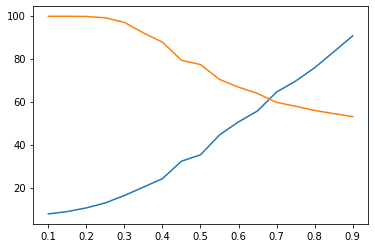

In [ ]:
plt.plot(thres, sample_pers)
plt.plot(thres, zer_pers)

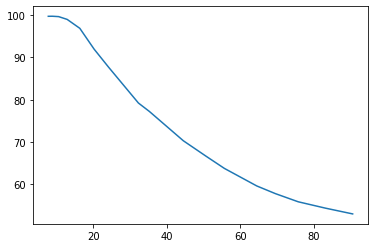

In [ ]:
plt.plot(sample_pers, zer_pers)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


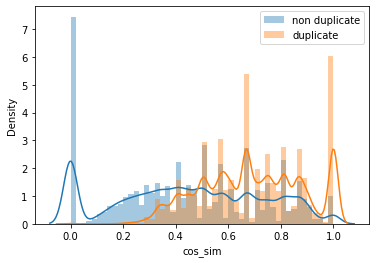

In [ ]:
sns.distplot(df[df['is_duplicate'] == 0]['cos_sim'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['cos_sim'],label='duplicate')
plt.legend()
plt.show()

## Basic Features
1. length of sentence
2. num of words in sentence
3. common words (if two sentences are being compared)
4. total words (sum of two if two sentences are being compared)
5. ratio of common words to total words

In [ ]:
# 1. Length of Questions

df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

In [ ]:
# 2. Number of Words in each Question

df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [ ]:
# 3. Number of Common Words

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

df['word_common'] = df.apply(common_words, axis=1)

In [ ]:
# 4. Number of Total Words

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

df['word_total'] = df.apply(total_words, axis=1)

In [ ]:
# 5. Ratio of Word Share

df['word_share'] = round(df['word_common']/df['word_total'],2)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cos_sim,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
81424,81424,161740,161741,cant india get medal every olympics,indian get le medal olympics,1,0.547731,35,28,6,5,3,11,0.27
350428,350428,686512,686513,car accident common among high school student ...,carriage accident le common car accident today,0,0.402021,61,46,9,7,3,14,0.21
162442,162442,321149,321150,conceptual analysis,conceptual model,0,0.500025,19,16,2,2,1,4,0.25
261498,261498,514570,514571,eye lord ring,powerful lord ring,0,0.666678,13,18,3,3,2,6,0.33
70085,70085,139301,139302,management art science,management science art,1,1.000000,22,22,3,3,3,6,0.50


## Token Features
1. cwc_min: This is the ratio of the number of common words to the length of the smaller question
2. cwc_max: This is the ratio of the number of common words to the length of the larger question
3. csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
4. csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
5. ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
6. ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
7. last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
8. first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

In [ ]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = nltk.corpus.stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [ ]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cos_sim,q1_len,q2_len,q1_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
81424,81424,161740,161741,cant india get medal every olympics,indian get le medal olympics,1,0.547731,35,28,6,...,11,0.27,0.599988,0.499992,0.0,0.0,0.599988,0.499992,1.0,0.0
350428,350428,686512,686513,car accident common among high school student ...,carriage accident le common car accident today,0,0.402021,61,46,9,...,14,0.21,0.499992,0.374995,0.0,0.0,0.428565,0.333330,0.0,0.0
162442,162442,321149,321150,conceptual analysis,conceptual model,0,0.500025,19,16,2,...,4,0.25,0.499975,0.499975,0.0,0.0,0.499975,0.499975,0.0,1.0
261498,261498,514570,514571,eye lord ring,powerful lord ring,0,0.666678,13,18,3,...,6,0.33,0.666644,0.666644,0.0,0.0,0.666644,0.666644,1.0,0.0
70085,70085,139301,139302,management art science,management science art,1,1.000000,22,22,3,...,6,0.50,0.999967,0.999967,0.0,0.0,0.999967,0.999967,0.0,1.0


## Length Features
1. mean_len: Mean of the length of the two questions (number of words)
2. abs_len_diff: Absolute difference between the length of the two questions (number of words)
3. longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

In [ ]:
def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) > 0:
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [ ]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

## Fuzzy Features
1. fuzz_ratio: fuzz_ratio score from fuzzywuzzy
2. fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
3. token_sort_ratio: token_sort_ratio from fuzzywuzzy
4. token_set_ratio: token_set_ratio from fuzzywuzzy

In [ ]:
def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = []
for i, row in tqdm(df.iterrows()):
    fuzzy_features.append(fetch_fuzzy_features(row))

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

298550it [09:23, 529.36it/s]


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cos_sim,q1_len,q2_len,q1_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
81424,81424,161740,161741,cant india get medal every olympics,indian get le medal olympics,1,0.547731,35,28,6,...,0.499992,1.0,0.0,1.0,5.5,0.310345,76,79,76,78
350428,350428,686512,686513,car accident common among high school student ...,carriage accident le common car accident today,0,0.402021,61,46,9,...,0.333330,0.0,0.0,2.0,8.0,0.276596,28,50,56,68
162442,162442,321149,321150,conceptual analysis,conceptual model,0,0.500025,19,16,2,...,0.499975,0.0,1.0,0.0,2.0,0.647059,69,75,57,77
261498,261498,514570,514571,eye lord ring,powerful lord ring,0,0.666678,13,18,3,...,0.666644,1.0,0.0,0.0,3.0,0.714286,71,77,58,82
70085,70085,139301,139302,management art science,management science art,1,1.000000,22,22,3,...,0.999967,0.0,1.0,0.0,3.0,0.478261,82,82,100,100


# **Visualizing**

In [ ]:
cols = list(df.columns)[6:]
cols

['cos_sim',
 'q1_len',
 'q2_len',
 'q1_num_words',
 'q2_num_words',
 'word_common',
 'word_total',
 'word_share',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'longest_substr_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'token_sort_ratio',
 'token_set_ratio']

In [ ]:
import warnings
warnings.filterwarnings("ignore")

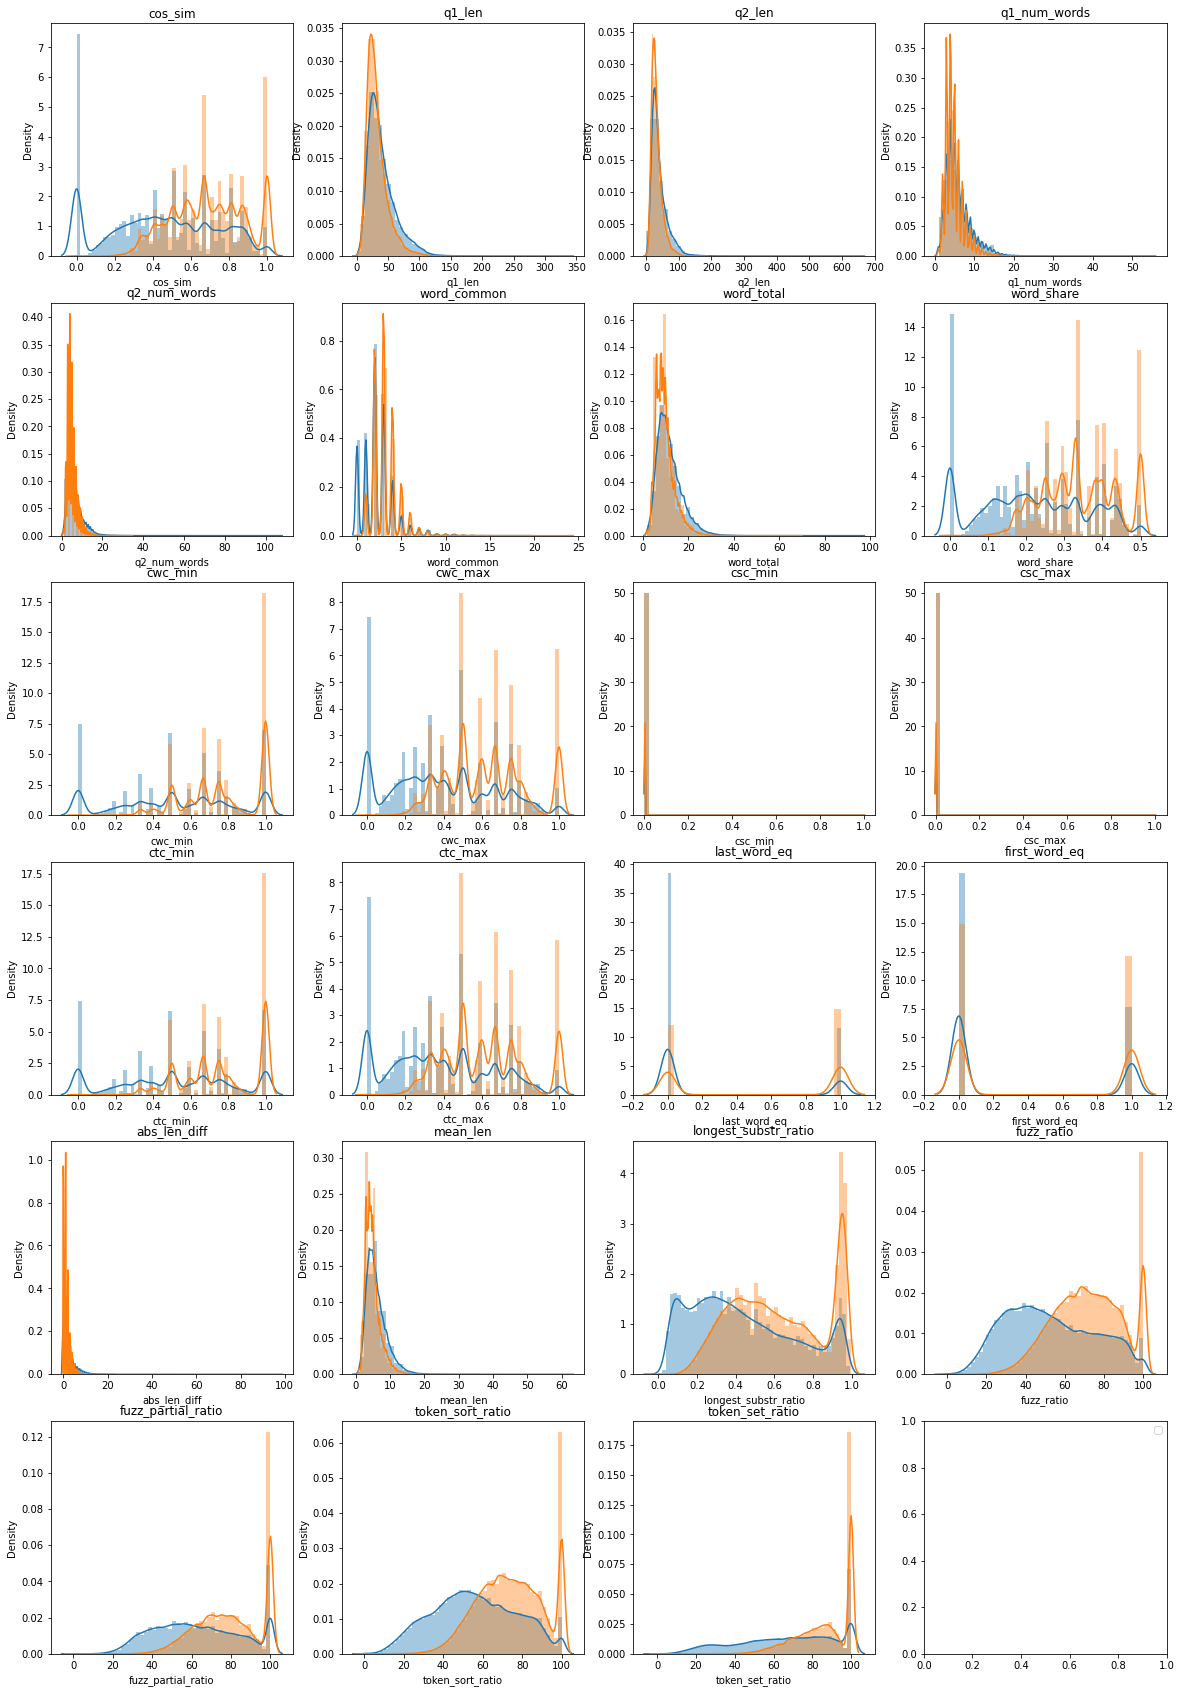

In [ ]:
n_cols = 4

n_rows = int(np.ceil(len(cols)/n_cols))
n_rows = max(n_rows, 2)
fig_size = 5

fig, axes = plt.subplots(
    n_rows,    # no of rows
    n_cols,    # no of cols
    figsize = (fig_size*n_cols, fig_size*n_rows),
)

for i, col in enumerate(cols):
    ax = axes[i//n_cols, i%n_cols]

    ax.set_title(cols[i])
    sns.distplot(df[df['is_duplicate'] == 0][col], label='non duplicate', ax=ax)
    sns.distplot(df[df['is_duplicate'] == 1][col], label='duplicate', ax=ax)

plt.legend()
plt.show()

# **Saving Preprocessed Data**

In [ ]:
df.index = range(len(df))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cos_sim,q1_len,q2_len,q1_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,81424,161740,161741,cant india get medal every olympics,indian get le medal olympics,1,0.547731,35,28,6,...,0.499992,1.0,0.0,1.0,5.5,0.310345,76,79,76,78
1,350428,686512,686513,car accident common among high school student ...,carriage accident le common car accident today,0,0.402021,61,46,9,...,0.333330,0.0,0.0,2.0,8.0,0.276596,28,50,56,68
2,162442,321149,321150,conceptual analysis,conceptual model,0,0.500025,19,16,2,...,0.499975,0.0,1.0,0.0,2.0,0.647059,69,75,57,77
3,261498,514570,514571,eye lord ring,powerful lord ring,0,0.666678,13,18,3,...,0.666644,1.0,0.0,0.0,3.0,0.714286,71,77,58,82
4,70085,139301,139302,management art science,management science art,1,1.000000,22,22,3,...,0.999967,0.0,1.0,0.0,3.0,0.478261,82,82,100,100


In [ ]:
# path = os.path.join(DUMP_PATH, f"more_preprocessed_data_{SAMPLE_SIZE}.csv")
path = os.path.join(DUMP_PATH, f"final_preprocessed_data_allowStopwords{int(ALLOW_STOPWORDS)}.csv")
path

'/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/final_preprocessed_data_allowStopwords0.csv'

In [ ]:
df.to_csv(path, index=False)